In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.6 MB/s 


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle as p
import warnings
import keras_tuner as kt
warnings.filterwarnings('ignore')

In [ ]:
HINDUNILVR = p.load(open("/content/drive/MyDrive/Colab Notebooks/Datasets/Indian/Final/HINDUNILVR_combined_v3.p",'rb'))

### Data Preprocessing

### Model

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 11

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
def model_builder(hp):
  model = tf.keras.models.Sequential()
  
  hp_lstm_1_units = hp.Int('units_lstm_1', min_value=16, max_value=126, step=16)
  hp_lstm_2_units = hp.Int('units_lstm_2', min_value=16, max_value=32, step=4)
  hp_dense_1_units = hp.Int('dense_1', min_value=32, max_value=126, step=16)
  hp_dense_2_units = hp.Int('dense_2', min_value=16, max_value=64, step=8)
  hp_dense_3_units = hp.Int('dense_3', min_value=8, max_value=32, step=4)

  model.add(tf.keras.layers.LSTM(hp_lstm_1_units, input_shape = (5, 22), activation = tf.nn.leaky_relu, return_sequences = True, \
                                                           kernel_initializer='random_normal',
                                                           bias_initializer='zeros'))
  
  model.add(tf.keras.layers.LSTM(hp_lstm_1_units, activation = tf.nn.leaky_relu))
  model.add(tf.keras.layers.Dense(hp_dense_1_units, activation = tf.nn.leaky_relu))
  model.add(tf.keras.layers.Dense(hp_dense_2_units, activation = tf.nn.leaky_relu))
  model.add(tf.keras.layers.Dense(hp_dense_3_units, activation = tf.nn.leaky_relu))
  model.add(tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=200,
                     factor=3, 
                     seed= 11)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# def Model():
#   model = tf.keras.models.Sequential([
#                                       tf.keras.layers.LSTM(80, input_shape = (5, 22), activation = tf.nn.leaky_relu, return_sequences = True, \
#                                                            kernel_initializer='random_normal',
#                                                            bias_initializer='zeros'),
#                                       tf.keras.layers.LSTM(40, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(60, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(30, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(15, activation = tf.nn.leaky_relu),
#                                       tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
#                                       ])
#   return model

In [ ]:
# model = Model()

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# model.summary()

### Custom Learning Rate

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#HINDUNILVR

In [ ]:
HINDUNILVR.tail()

,stock_open,stock_high,stock_low,stock_close,stock_adjclose_target,Volume,SMA,EMA,nifty50_price,nifty50_open,nifty50_high,nifty50_low,nifty50_Vol.,nifty50_Chg%,niftybank_price,niftybank_open,niftybank_high,niftybank_low,niftybank_Vol.,niftybank_Change %,Sales,Expenses,Material Cost,Employee Cost,Operating Profit,OPM,Other Income,Interest,Depreciation,Profit before tax,Tax,Net Profit,EPS in Rs,"Agriculture, Forestry and Fishing",Mining & Quarrying,Manufacturing,"Electricity, Gas, Water Supply & Other Utility",Construction,"Trade, Hotels, Transport, Communication and Services Related to Broadcasting","Financial, Real Estate and Professional Services","Public Administration, Defence and Other Services",Total Gross Value Added at Basic Price,CPI Index,CPI Index Previous Month,CPI Index Previous Quarter,CPI Index Previous Year,by_Closing_Price,by_Open,by_High,by_Low,by_Change%,Per_chg_qgdp,CPI_monthly_oecd,cli_monthly,ShPrice_monthly
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-24,2406.000000,2406.00,2367.000000,2374.750000,2374.750000,999070.0,2396.76,2398.7034,17415.05,17550.05,17600.60,17354.0,298050000.0,-0.50,37441.95,37384.75,37891.90,37238.05,157620000.0,0.45,13439.0,10030.0,47.72,5.15,3409.0,25.0,-7.0,27.0,272.0,3103.0,26.0,2297.0,9.78,407640.6354,70021.52469,586774.7019,86329.84504,240527.8671,579112.5787,845467.9951,472860.9456,3288736.094,163.2,162.9,159.83,156.4,6.367,6.390,6.390,6.363,0.05,12.6866,4.837365,100.217,217.3347
2021-11-25,2387.000000,2387.00,2341.000000,2349.050049,2349.050049,1363272.0,2391.62,2389.8210,17536.25,17417.30,17564.35,17351.7,255950000.0,0.70,37364.75,37362.05,37507.95,37118.40,140760000.0,-0.21,13439.0,10030.0,47.72,5.15,3409.0,25.0,-7.0,27.0,272.0,3103.0,26.0,2297.0,9.78,407640.6354,70021.52469,586774.7019,86329.84504,240527.8671,579112.5787,845467.9951,472860.9456,3288736.094,163.2,162.9,159.83,156.4,6.367,6.376,6.376,6.366,0.00,12.6866,4.837365,100.217,217.3347
2021-11-26,2344.000000,2365.00,2325.199951,2335.100098,2335.100098,2450902.0,2387.50,2379.8081,17026.45,17338.75,17355.40,16985.7,356330000.0,-2.91,36025.50,36830.90,36868.90,35904.10,211360000.0,-3.58,13439.0,10030.0,47.72,5.15,3409.0,25.0,-7.0,27.0,272.0,3103.0,26.0,2297.0,9.78,407640.6354,70021.52469,586774.7019,86329.84504,240527.8671,579112.5787,845467.9951,472860.9456,3288736.094,163.2,162.9,159.83,156.4,6.330,6.338,6.338,6.319,-0.58,12.6866,4.837365,100.217,217.3347
2021-11-29,2334.399902,2342.25,2284.699951,2329.399902,2329.399902,1724612.0,2379.71,2370.5884,17053.95,17055.80,17160.70,16782.4,348890000.0,0.16,35976.45,36224.45,36347.85,35327.90,187220000.0,-0.14,13439.0,10030.0,47.72,5.15,3409.0,25.0,-7.0,27.0,272.0,3103.0,26.0,2297.0,9.78,407640.6354,70021.52469,586774.7019,86329.84504,240527.8671,579112.5787,845467.9951,472860.9456,3288736.094,163.2,162.9,159.83,156.4,6.335,6.375,6.375,6.329,0.08,12.6866,4.837365,100.217,217.3347
2021-11-30,2322.000000,2361.00,2302.000000,2317.550049,2317.550049,3931035.0,2369.12,2361.1087,16983.20,17051.15,17324.65,16931.4,498000000.0,-0.41,35695.30,35958.80,36774.20,35526.35,227280000.0,-0.78,13439.0,10030.0,47.72,5.15,3409.0,25.0,-7.0,27.0,272.0,3103.0,26.0,2297.0,9.78,407640.6354,70021.52469,586774.7019,86329.84504,240527.8671,579112.5787,845467.9951,472860.9456,3288736.094,163.2,162.9,159.83,156.4,6.326,6.331,6.342,6.307,-0.14,12.6866,4.837365,100.217,217.3347


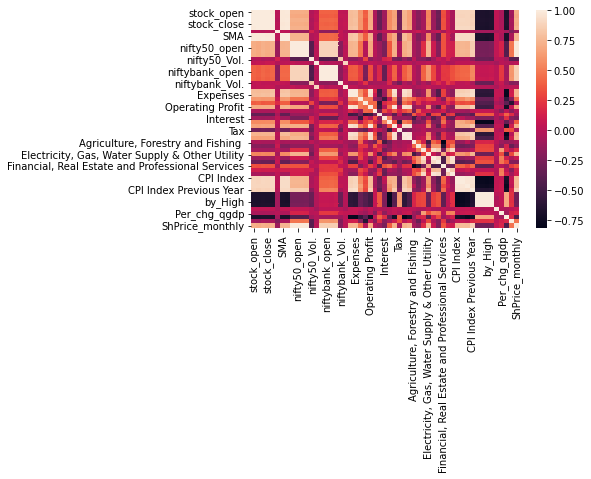

In [ ]:
sns.heatmap(HINDUNILVR.corr())

In [ ]:
HINDUNILVR.corr()

,stock_open,stock_high,stock_low,stock_close,stock_adjclose_target,Volume,SMA,EMA,nifty50_price,nifty50_open,nifty50_high,nifty50_low,nifty50_Vol.,nifty50_Chg%,niftybank_price,niftybank_open,niftybank_high,niftybank_low,niftybank_Vol.,niftybank_Change %,Sales,Expenses,Material Cost,Employee Cost,Operating Profit,OPM,Other Income,Interest,Depreciation,Profit before tax,Tax,Net Profit,EPS in Rs,"Agriculture, Forestry and Fishing",Mining & Quarrying,Manufacturing,"Electricity, Gas, Water Supply & Other Utility",Construction,"Trade, Hotels, Transport, Communication and Services Related to Broadcasting","Financial, Real Estate and Professional Services","Public Administration, Defence and Other Services",Total Gross Value Added at Basic Price,CPI Index,CPI Index Previous Month,CPI Index Previous Quarter,CPI Index Previous Year,by_Closing_Price,by_Open,by_High,by_Low,by_Change%,Per_chg_qgdp,CPI_monthly_oecd,cli_monthly,ShPrice_monthly
stock_open,1.000000,0.995712,0.996900,0.993069,0.992648,-0.001209,0.983113,0.987069,0.706443,0.706485,0.710029,0.702498,-0.027658,0.040348,0.397225,0.397122,0.403084,0.389697,0.039844,0.032499,0.775300,0.791772,0.610141,0.377632,0.697955,-0.045801,-0.345348,-0.092252,0.558713,0.665527,-0.286043,0.740662,0.656149,-0.053238,-0.197071,-0.075794,0.543536,-0.115556,-0.324982,0.332931,0.109726,-0.063190,0.897150,0.898223,0.898555,0.879500,-0.679822,-0.679128,-0.684749,-0.673859,0.040602,-0.049552,-0.676905,-0.077416,0.715976
stock_high,0.995712,1.000000,0.994634,0.996962,0.995268,0.011587,0.979102,0.983733,0.687804,0.686505,0.691655,0.682482,-0.002741,0.058892,0.378302,0.377040,0.384606,0.369322,0.053828,0.042000,0.766548,0.782646,0.616792,0.397598,0.690585,-0.041440,-0.348316,-0.087437,0.559328,0.656372,-0.298998,0.735803,0.648363,-0.041895,-0.188295,-0.073019,0.531597,-0.108920,-0.313791,0.322222,0.116706,-0.055089,0.890021,0.891843,0.893479,0.869664,-0.682851,-0.681937,-0.686954,-0.677523,0.039921,-0.050017,-0.680816,-0.102710,0.698830
stock_low,0.996900,0.994634,1.000000,0.996668,0.996485,-0.010231,0.981877,0.986269,0.720915,0.719885,0.723502,0.717194,-0.046072,0.054597,0.413458,0.412321,0.418117,0.406341,0.028574,0.041710,0.778407,0.795559,0.605166,0.356945,0.699078,-0.050226,-0.339722,-0.094689,0.559322,0.667965,-0.275155,0.739565,0.657697,-0.057591,-0.202767,-0.078066,0.550963,-0.119632,-0.333990,0.339879,0.099236,-0.069185,0.900610,0.901947,0.900238,0.884702,-0.676189,-0.675634,-0.681603,-0.669670,0.038018,-0.053844,-0.670023,-0.048452,0.729062
stock_close,0.993069,0.996962,0.996668,1.000000,0.998943,0.006625,0.978453,0.983458,0.705838,0.703406,0.708402,0.700573,-0.024726,0.078800,0.397586,0.395219,0.402394,0.388871,0.039606,0.055990,0.772960,0.789761,0.610221,0.374316,0.694814,-0.045722,-0.343059,-0.090002,0.562472,0.661996,-0.288726,0.738012,0.653707,-0.052070,-0.197204,-0.075451,0.542633,-0.114713,-0.324748,0.333251,0.105386,-0.062965,0.896500,0.898580,0.897628,0.878300,-0.681966,-0.681272,-0.686596,-0.675959,0.035943,-0.050453,-0.675313,-0.069219,0.715451
stock_adjclose_target,0.992648,0.995268,0.996485,0.998943,1.000000,0.003344,0.982294,0.987318,0.727259,0.724996,0.729919,0.722043,-0.039324,0.074480,0.415950,0.413737,0.420873,0.407231,0.030305,0.052950,0.794404,0.811262,0.613611,0.367976,0.715205,-0.043353,-0.347066,-0.089504,0.571030,0.683366,-0.286683,0.757826,0.675519,-0.059722,-0.207487,-0.074697,0.563996,-0.118026,-0.335966,0.344983,0.098370,-0.067714,0.912205,0.914780,0.912803,0.898110,-0.686907,-0.686331,-0.691766,-0.680735,0.039035,-0.039383,-0.686084,-0.046286,0.737709
Volume,-0.001209,0.011587,-0.010231,0.006625,0.003344,1.000000,0.023298,0.019913,-0.118401,-0.117369,-0.116365,-0.118780,0.129819,-0.020413,-0.167164,-0.165594,-0.164663,-0.167514,0.051933,-0.030061,-0.008981,-0.012967,0.074467,0.187108,0.002255,0.035995,-0.051159,0.037008,0.022804,-0.011365,-0.095007,0.018056,-0.015269,0.034940,0.089950,0.013958,-0.066352,0.030552,0.069065,-0.068857,0.072261,0.040175,0.006414,0.012786,0

In [ ]:
HINDUNILVR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2019-01-01 to 2021-11-30
Data columns (total 55 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   stock_open                                                                    719 non-null    float64
 1   stock_high                                                                    719 non-null    float64
 2   stock_low                                                                     719 non-null    float64
 3   stock_close                                                                   719 non-null    float64
 4   stock_adjclose_target                                                         719 non-null    float64
 5   Volume                                                                        719 non-null    float64
 6   SMA            

In [ ]:
# Resetting index to get date as an attribute
HINDUNILVR.reset_index(inplace=True)

In [ ]:
# Defining training columns
trainCols = HINDUNILVR.columns.tolist()
trainCols.remove('stock_adjclose_target')
trainCols.remove('Date')

In [ ]:
trainCols = ['stock_open', 'EMA', 'SMA', 'CPI Index Previous Month',
       'Expenses', 'Sales','ShPrice_monthly', 'nifty50_price', 'Operating Profit',
       'by_Closing_Price', 'CPI_monthly_oecd',
       'EPS in Rs', 'Material Cost', 'Depreciation',
       'Electricity, Gas, Water Supply & Other Utility',
       'niftybank_price', 'Employee Cost',
       'Trade, Hotels, Transport, Communication and Services Related to Broadcasting',
       'Financial, Real Estate and Professional Services', 'Other Income',
       'Tax', 'Mining & Quarrying']

In [ ]:
len(trainCols)

22

In [ ]:
# Change Dtype of date column
HINDUNILVR["Date"] = pd.to_datetime(HINDUNILVR["Date"])

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-29

In [ ]:
def Dataset(Data, train_cols, target_col, datecol,date):
  Train_Data = HINDUNILVR[HINDUNILVR[datecol] < pd.to_datetime(date)]
  # print(Train_Data.shape)
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, Train_Data.shape[0], 5):
    # print(i)
    Data_Train_X.append(Train_Data.loc[i : i + 4,trainCols].to_numpy())
    Data_Train_Y.append(Train_Data.loc[i : i + 4,target_col].to_numpy())

  if len(Data_Train_X[-1]) < 5:
    Data_Train_X.pop(-1)
    Data_Train_Y.pop(-1)

  Data_Train_X = Data_Train_X[:-1]
  Data_Train_Y = Data_Train_Y[1:]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_Y = np.array(Data_Train_Y)
  # Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))

  Test_Data = HINDUNILVR[HINDUNILVR[datecol] >= pd.to_datetime(date)]
  Test_Data.reset_index(inplace=True)
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, Test_Data.shape[0], 5):
    # print(i)
    Data_Test_X.append(Test_Data.loc[i : i + 4,trainCols].to_numpy())
    Data_Test_Y.append(Test_Data.loc[i : i + 4,target_col].to_numpy())

  print(len(Data_Test_X[-1]))

  if len(Data_Test_X[-1]) < 5:
    Data_Test_X.pop(-1)
    Data_Test_Y.pop(-1)

  Data_Test_X = Data_Test_X[:-1]
  Data_Test_Y = Data_Test_Y[1:]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_Y = np.array(Data_Test_Y)
  # Data_Test_X = Data_Test_X.reshape((-1, 5, 54))
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

In [ ]:
HINDUNILVR.columns

Index(['Date', 'stock_open', 'stock_high', 'stock_low', 'stock_close',
       'stock_adjclose_target', 'Volume', 'SMA', 'EMA', 'nifty50_price',
       'nifty50_open', 'nifty50_high', 'nifty50_low', 'nifty50_Vol.',
       'nifty50_Chg%', 'niftybank_price', 'niftybank_open', 'niftybank_high',
       'niftybank_low', 'niftybank_Vol.', 'niftybank_Change %', 'Sales',
       'Expenses', 'Material Cost', 'Employee Cost', 'Operating Profit', 'OPM',
       'Other Income', 'Interest', 'Depreciation', 'Profit before tax', 'Tax',
       'Net Profit', 'EPS in Rs', 'Agriculture, Forestry and Fishing ',
       'Mining & Quarrying', 'Manufacturing',
       'Electricity, Gas, Water Supply & Other Utility', 'Construction',
       'Trade, Hotels, Transport, Communication and Services Related to Broadcasting',
       'Financial, Real Estate and Professional Services',
       'Public Administration, Defence and Other Services',
       'Total Gross Value Added at Basic Price', 'CPI Index',
       'CPI Index

In [ ]:
HINDUNILVR_date = '2021-08-01'
HINDUNILVR_Train_X, HINDUNILVR_Train_Y, HINDUNILVR_Test_X, HINDUNILVR_Test_Y = Dataset(HINDUNILVR, trainCols, 'stock_adjclose_target', 'Date', HINDUNILVR_date)

2


In [ ]:
print(HINDUNILVR[HINDUNILVR['Date'] < pd.to_datetime(HINDUNILVR_date)].shape)
print(HINDUNILVR[HINDUNILVR['Date'] >= pd.to_datetime(HINDUNILVR_date)].shape)

(637, 56)
(82, 56)


In [ ]:
HINDUNILVR_Train_X.shape, HINDUNILVR_Train_Y.shape, HINDUNILVR_Test_X.shape, HINDUNILVR_Test_Y.shape

((126, 5, 22), (126, 5, 1), (15, 5, 22), (15, 5, 1))

In [ ]:
HINDUNILVR.head(20)

,Date,stock_open,stock_high,stock_low,stock_close,stock_adjclose_target,Volume,SMA,EMA,nifty50_price,nifty50_open,nifty50_high,nifty50_low,nifty50_Vol.,nifty50_Chg%,niftybank_price,niftybank_open,niftybank_high,niftybank_low,niftybank_Vol.,niftybank_Change %,Sales,Expenses,Material Cost,Employee Cost,Operating Profit,OPM,Other Income,Interest,Depreciation,Profit before tax,Tax,Net Profit,EPS in Rs,"Agriculture, Forestry and Fishing",Mining & Quarrying,Manufacturing,"Electricity, Gas, Water Supply & Other Utility",Construction,"Trade, Hotels, Transport, Communication and Services Related to Broadcasting","Financial, Real Estate and Professional Services","Public Administration, Defence and Other Services",Total Gross Value Added at Basic Price,CPI Index,CPI Index Previous Month,CPI Index Previous Quarter,CPI Index Previous Year,by_Closing_Price,by_Open,by_High,by_Low,by_Change%,Per_chg_qgdp,CPI_monthly_oecd,cli_monthly,ShPrice_monthly
0,2019-01-01,1824.800049,1824.800049,1798.349976,1801.099976,1724.875488,807345.0,1738.1701,1735.8919,10910.10,10881.70,10923.60,10807.10,159400000.0,0.44,27392.40,27231.40,27430.55,27019.05,116380000.0,0.85,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.418,7.401,7.447,7.385,0.65,1.56202,6.597222,101.1468,131.7876
1,2019-01-02,1792.400024,1808.849976,1771.300049,1784.599976,1709.073975,1598707.0,1732.7018,1730.9118,10792.50,10868.85,10895.35,10735.05,309670000.0,-1.08,27174.70,27297.00,27397.55,27077.60,176600000.0,-0.79,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.354,7.409,7.415,7.350,-0.86,1.56202,6.597222,101.1468,131.7876
2,2019-01-03,1782.599976,1803.449951,1782.599976,1788.400024,1712.713379,1182624.0,1727.2765,1727.4205,10672.25,10796.80,10814.05,10661.25,286240000.0,-1.11,26959.85,27181.60,27206.20,26923.75,151200000.0,-0.79,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.427,7.397,7.433,7.381,0.99,1.56202,6.597222,101.1468,131.7876
3,2019-01-04,1798.900024,1802.000000,1772.150024,1781.699951,1706.296753,1454134.0,1722.1386,1723.3276,10727.35,10699.70,10741.05,10628.65,296600000.0,0.52,27195.00,26999.70,27274.50,26926.10,189450000.0,0.87,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.448,7.407,7.475,7.406,0.28,1.56202,6.597222,101.1468,131.7876
4,2019-01-07,1791.500000,1804.000000,1782.449951,1784.949951,1709.409058,909032.0,1720.3285,1720.7538,10771.80,10804.85,10835.95,10750.15,269370000.0,0.41,27304.55,27378.65,27477.80,27279.55,161030000.0,0.40,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.508,7.467,7.519,7.439,0.81,1.56202,6.597222,101.1468,131.7876
5,2019-01-08,1792.000000,1793.500000,1761.099976,1770.849976,1695.905884,1262707.0,1719.0884,1716.1928,10802.15,10786.25,10818.45,10733.25,277700000.0,0.28,27509.50,27301.90,27542.40,27161.95,150550000.0,0.75,10201.0,7807.0,47.54,4.23,2394.0,23.0,49.0,7.0,144.0,2292.0,31.0,1571.0,7.26,592114.9268,80276.72475,563029.3515,72791.51775,260461.6199,620292.0437,587988.538,419392.0031,3196346.726,139.6,140.2,140.53,136.9,7.454,7.503,7.534,7.439,-0.72,1.56202,6.597222,101.1468,131.7876
6,2019-01-09,1777.500000,1797.000000,1773.400024,1785.000000,1709.457153,1324628.0,1718.3270,1714.6550,10855.15,10862.40,10870.40,10749.40,333010000.0,0.49,

In [ ]:
HINDUNILVR_Train_X[0], HINDUNILVR_Train_Y[0], HINDUNILVR_Test_X[0], HINDUNILVR_Test_Y[0]

(array([[1.82480005e+03, 1.73589190e+03, 1.73817010e+03, 1.40200000e+02,
         7.80700000e+03, 1.02010000e+04, 1.31787600e+02, 1.09101000e+04,
         2.39400000e+03, 7.41800000e+00, 6.59722200e+00, 7.26000000e+00,
         4.75400000e+01, 1.44000000e+02, 7.27915177e+04, 2.73924000e+04,
         4.23000000e+00, 6.20292044e+05, 5.87988538e+05, 4.90000000e+01,
         3.10000000e+01, 8.02767247e+04],
        [1.79240002e+03, 1.73091180e+03, 1.73270180e+03, 1.40200000e+02,
         7.80700000e+03, 1.02010000e+04, 1.31787600e+02, 1.07925000e+04,
         2.39400000e+03, 7.35400000e+00, 6.59722200e+00, 7.26000000e+00,
         4.75400000e+01, 1.44000000e+02, 7.27915177e+04, 2.71747000e+04,
         4.23000000e+00, 6.20292044e+05, 5.87988538e+05, 4.90000000e+01,
         3.10000000e+01, 8.02767247e+04],
        [1.78259998e+03, 1.72742050e+03, 1.72727650e+03, 1.40200000e+02,
         7.80700000e+03, 1.02010000e+04, 1.31787600e+02, 1.06722500e+04,
         2.39400000e+03, 7.42700000e+00,

### Model Fitting

In [ ]:
tuner.search(HINDUNILVR_Train_X, HINDUNILVR_Train_Y, epochs = 200, validation_data = (HINDUNILVR_Test_X, HINDUNILVR_Test_Y), callbacks=[callback])

Trial 102 Complete [00h 00m 03s]
val_loss: 482498.90625

Best val_loss So Far: 178256.671875
Total elapsed time: 00h 05m 51s

Search: Running Trial #103

Hyperparameter    |Value             |Best Value So Far 
units             |48                |64                
learning_rate     |0.01              |0.001             
tuner/epochs      |8                 |3                 
tuner/initial_e...|3                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |1                 |0                 
tuner/trial_id    |f5e30f8c0c19c12...|None              



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-125-2d5a74ee9eee>", line 4, in model_builder
    hp_lstm_1_units = hp.Int('units_lstm_1', min_value=16, max_value=126, step=16)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 847, in Int
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 704, in _retrieve
    return self.values[hp.name]
KeyError: 'units_lstm_1'


Invalid model 0/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-125-2d5a74ee9eee>", line 4, in model_builder
    hp_lstm_1_units = hp.Int('units_lstm_1', min_value=16, max_value=126, step=16)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 847, in Int
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 704, in _retrieve
    return self.values[hp.name]
KeyError: 'units_lstm_1'


Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-125-2d5a74ee9eee>", line 4, in model_builder
    hp_lstm_1_units = hp.Int('units_lstm_1', min_value=16, max_value=126, step=16)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 847, in Int
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 704, in _retrieve
    return self.values[hp.name]
KeyError: 'units_lstm_1'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras

Invalid model 2/5
Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-125-2d5a74ee9eee>", line 4, in model_builder
    hp_lstm_1_units = hp.Int('units_lstm_1', min_value=16, max_value=126, step=16)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 847, in Int
    return self._retrieve(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 704, in _retrieve
    return self.values[hp.name]
KeyError: 'units_lstm_1'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras

RuntimeError: ignored

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in layer are {best_hps.get('units_lstm_1')} and {best_hps.get('units_lstm_2')} and
{best_hps.get('dense_1')} and {best_hps.get('dense_2')} and {best_hps.get('dense_3')}
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. """)


The hyperparameter search is complete. The optimal number of units in layer are 32 and 20 and
64 and 56 and 20
and the optimal learning rate for the optimizer is 0.001. 


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model_hist = best_model.fit(HINDUNILVR_Train_X, HINDUNILVR_Train_Y, epochs = 200, validation_data = (HINDUNILVR_Test_X, HINDUNILVR_Test_Y), callbacks=[callback])

Epoch 1/200
4/4 [==============================] - 3s 144ms/step - loss: 3462934.7500 - root_mean_squared_error: 1860.8962 - val_loss: 5028131.5000 - val_root_mean_squared_error: 2242.3496
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 1737599.0000 - root_mean_squared_error: 1318.1801 - val_loss: 4294883.5000 - val_root_mean_squared_error: 2072.4102
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 1339507.0000 - root_mean_squared_error: 1157.3707 - val_loss: 4049439.5000 - val_root_mean_squared_error: 2012.3219
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 1000954.8750 - root_mean_squared_error: 1000.4773 - val_loss: 3703001.5000 - val_root_mean_squared_error: 1924.3186
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 903869.1875 - root_mean_squared_error: 950.7203 - val_loss: 3263308.2500 - val_root_mean_squared_error: 1806.4629
Epoch 6/200
4/4 [==============================] - 0s 17ms/st

In [ ]:
history_dict = best_model_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

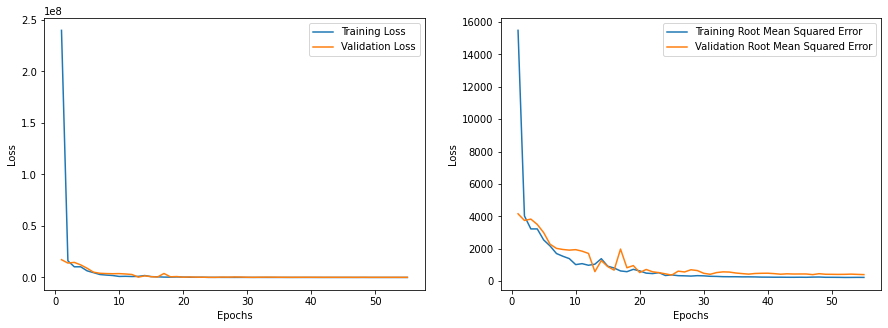

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of HINDUNILVR

In [ ]:
HINDUNILVR_prediction = best_model.predict(HINDUNILVR_Test_X)

In [ ]:
HINDUNILVR_prediction

array([[2518.5757, 2489.2869, 2411.7197, 2341.176 , 2587.7842],
       [2517.9727, 2488.7947, 2411.6257, 2341.2031, 2587.0503],
       [2518.6465, 2488.9062, 2411.6887, 2341.1196, 2587.7305],
       [2521.6235, 2490.9321, 2413.4395, 2342.8452, 2590.8013],
       [2523.5547, 2491.9019, 2415.2559, 2345.0676, 2592.4126],
       [2524.525 , 2492.4197, 2415.757 , 2345.5408, 2593.394 ],
       [2522.2705, 2490.4502, 2414.8347, 2344.8887, 2590.752 ],
       [2523.8289, 2491.2104, 2416.0027, 2346.2424, 2592.127 ],
       [2381.8198, 2318.4568, 2261.6248, 2376.6313, 2485.5552],
       [2418.318 , 2330.8481, 2319.7305, 2416.7095, 2482.9773],
       [2421.4202, 2333.3142, 2322.4578, 2419.3682, 2485.5596],
       [2418.419 , 2331.5066, 2321.3972, 2418.9238, 2483.7559],
       [2416.02  , 2329.6658, 2319.4858, 2417.0781, 2481.7544],
       [2416.8687, 2330.2976, 2320.045 , 2417.5208, 2482.3525],
       [2417.7944, 2330.7202, 2320.1663, 2417.337 , 2482.702 ]],
      dtype=float32)

In [ ]:
HINDUNILVR[HINDUNILVR['Date'] >= '2021-08-01']['stock_adjclose_target'].values

array([2318.551514, 2372.271484, 2362.581055, 2343.299316, 2357.015137,
       2369.935791, 2367.252441, 2375.849365, 2377.688232, 2389.813721,
       2411.579834, 2468.629395, 2470.865479, 2603.400879, 2618.060791,
       2616.917969, 2628.844727, 2650.11377 , 2661.593506, 2671.283936,
       2707.46167 , 2716.207764, 2783.94165 , 2749.80127 , 2763.616455,
       2760.734131, 2783.79248 , 2793.48291 , 2769.331543, 2745.676758,
       2758.497803, 2751.341797, 2705.622803, 2783.24585 , 2795.271973,
       2767.492676, 2765.306152, 2729.873779, 2692.950684, 2707.213135,
       2668.898682, 2685.297852, 2687.53418 , 2669.792969, 2692.105713,
       2669.644043, 2653.095459, 2623.925049, 2628.944092, 2659.804443,
       2630.583984, 2633.366943, 2637.789795, 2531.244629, 2463.510742,
       2430.811768, 2439.11084 , 2440.850098, 2436.850098, 2396.600098,
       2389.649902, 2393.149902, 2407.100098, 2418.899902, 2411.350098,
       2422.850098, 2431.899902, 2431.149902, 2400.149902, 2376.

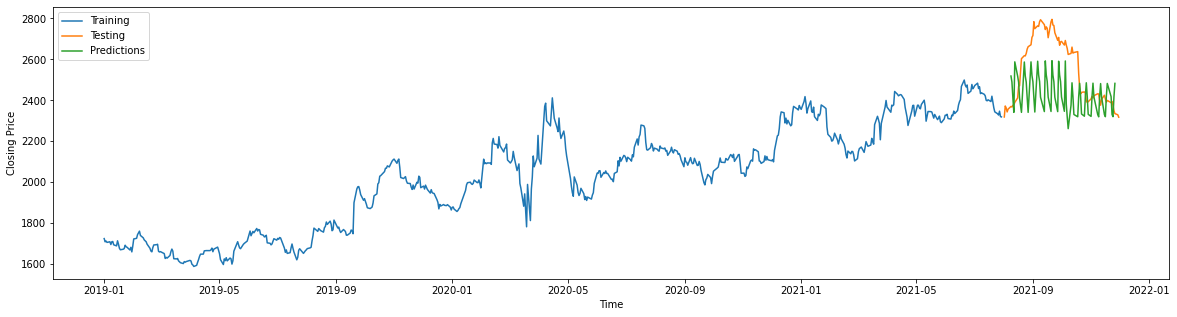

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(HINDUNILVR['Date'][HINDUNILVR['Date'] < '2021-08-01'], HINDUNILVR['stock_adjclose_target'][HINDUNILVR['Date'] < '2021-08-01'], label = 'Training')
plt.plot(HINDUNILVR['Date'][HINDUNILVR['Date'] >= '2021-08-01'], HINDUNILVR['stock_adjclose_target'][HINDUNILVR['Date'] >= '2021-08-01'], label = 'Testing')
plt.plot(HINDUNILVR['Date'][HINDUNILVR['Date'] >= '2021-08-01'].values[5:-2], HINDUNILVR_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(HINDUNILVR_Test_Y.reshape(-1, 5), HINDUNILVR_prediction))
mape = np.mean(np.abs(HINDUNILVR_prediction - HINDUNILVR_Test_Y.reshape(-1, 5))/np.abs(HINDUNILVR_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 204.46313156557824
MAPE: 0.06299294619551303
